# Cancer Detection Using CNN and Pythorch

The Histopathologic Cancer Detection competition on Kaggle challenges participants to develop an algorithm that can identify metastatic cancer in small image patches taken from larger digital pathology scans of lymph node sections.

## Problem Description:

You are provided with a large set of small color images (96x96 pixels) extracted from histopathologic scans of lymph node sections.

Each image must be classified as either containing metastatic tumor tissue or not—a binary classification task.

A positive label means the center 32x32 pixel region of the patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region does not influence the label, but is included to support fully convolutional models and ensure consistent predictions when applied to whole-slide images.

The dataset includes a CSV file (train_labels.csv) providing ground truth labels for the training images, and you are to predict labels for the test images.

The competition uses a slightly modified version of the PatchCamelyon (PCam) benchmark dataset, with duplicates removed.

## Goal:
Build a machine learning model that can accurately classify these image patches for the presence of metastatic cancer, aiding in the automation of pathology workflows.

## Evaluation Metric:
Submissions are evaluated using the Area Under the ROC Curve (AUC) between the predicted probabilities and the observed targets.

This competition is a classic computer vision challenge in medical imaging, aimed at improving cancer detection accuracy and efficiency in clinical settings

[Link to Kaggle competition](https://www.kaggle.com/competitions/histopathologic-cancer-detection)

In [ ]:
# import libraries
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import torch
import torch.nn as nn

from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score

from torch.utils.data import DataLoader, Dataset, Subset
from torchvision.io import decode_image
from torchvision import transforms

from torchsummary import summary

In [ ]:
# set some constants
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

BATCH_SIZE= 64
SAMPLE_N = None # set to None for training in full dataset
LR = 0.001
EPOCHS = 10

annotations_file = '/kaggle/input/histopathologic-cancer-detection/train_labels.csv'
img_dir = "/kaggle/input/histopathologic-cancer-detection/train/"

In [ ]:
class HistoData(Dataset):
    '''Dataset object for image loading'''
    def __init__(self, df, base_path, transform=None):
        self.df = df
        self.transform = transform or transforms.ToTensor()  # Default conversion
        self.base_path = base_path

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.base_path, self.df.iloc[idx]['id'] + '.tif')
        image = Image.open(img_path)
        label = self.df.iloc[idx]['label']
        
        if self.transform:
            image = self.transform(image)
            
        return image, torch.tensor(label, dtype=torch.float32), self.df.iloc[idx]['id']

    def get_random_indices(self, n):
        return random.sample(range(self.__len__()), n)
    
    def display_sample(self,n):
        rand_indices = self.get_random_indices(n)
        grid_size = int(np.ceil(np.sqrt(n)))
        plt.figure(figsize=(grid_size*2, grid_size*2))
        for idx, i in enumerate(rand_indices):
            image, label, _ = self.__getitem__(i)
            # Convert tensor to numpy and permute for matplotlib (C, H, W) -> (H, W, C)
            if isinstance(image, torch.Tensor):
                img = image.permute(1, 2, 0).cpu().numpy()
                # If normalized, unnormalize for display (optional, adjust mean/std as needed)
                # img = img * std + mean
                img = np.clip(img, 0, 1)
            else:
                img = np.array(image)
            plt.subplot(grid_size, grid_size, idx + 1)
            plt.imshow(img)
            plt.title(f'{int(label.item())}')
            plt.axis('off')
        plt.tight_layout()
        plt.show()

        print('Image Size:',image.size())  # Output: (width, height)

# EDA

## Inspect and explore metadata

In [ ]:
df = pd.read_csv(annotations_file)
# Prepare datasets for training and validation data
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'])

train_df.info()

In [ ]:
# print the number of records per label type
# 0 = non-malignant
# 1 = malignant
train_df['label'].value_counts()

In [ ]:
# Create datasets
train_dataset = HistoData(train_df, img_dir)
val_dataset = HistoData(val_df, img_dir)

train_subset = None
val_subset = None
if SAMPLE_N is not None:
    train_subset = Subset(train_dataset, train_dataset.get_random_indices(SAMPLE_N))
    val_subset = Subset(val_dataset, val_dataset.get_random_indices(int(SAMPLE_N*0.2)))

# Create dataloaders
train_loader = DataLoader(train_dataset if train_subset is None else train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset if val_subset is None else val_subset, batch_size=BATCH_SIZE)

In [ ]:
# before normalization
train_dataset.display_sample(9)

## Image normalization

Transformer normalization is crucial for stable, efficient, and effective training of deep transformer architectures

In [ ]:
# Find values for transformer normalization
# Remove comments if is needed a new calculation
'''mean = 0.
std = 0.
total_images = 0

for images, _, _ in train_loader:
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    total_images += batch_samples

mean /= total_images
std /= total_images

print(mean, std)'''

MEANS_NORM = [0.7019, 0.5456, 0.6961]
STD_NORM = [0.1815, 0.2011, 0.1649]

In [ ]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),  # Must be included before normalization
    transforms.Normalize(mean=MEANS_NORM, std=STD_NORM)
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=MEANS_NORM, std=STD_NORM)
])

# Create datasets
train_dataset_norm = HistoData(train_df, img_dir, transform=train_transform)
val_dataset_norm = HistoData(val_df, img_dir, transform=val_transform)

train_subset_norm = None
val_subset_norm = None
if SAMPLE_N is not None:
    train_subset_norm = Subset(train_dataset_norm, train_dataset.get_random_indices(SAMPLE_N))
    val_subset_norm = Subset(val_dataset_norm, val_dataset.get_random_indices(int(SAMPLE_N*0.2)))

# Create dataloaders
train_loader_norm = DataLoader(train_dataset_norm if train_subset_norm is None else train_subset_norm, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader_norm = DataLoader(val_dataset_norm if val_subset_norm is None else val_subset_norm, batch_size=BATCH_SIZE)


In [ ]:
#after normalization
train_dataset_norm.display_sample(9)

## Build the CNN architecture

### Model 1

This model consists of three convolutional layers (with ReLU activations and max pooling for downsampling), followed by flattening and two fully connected (linear) layers. The network has about 171,000 trainable parameters and is designed to extract features from input images and predict a binary output, making it suitable for tasks like medical image classificatio

In [ ]:
# CNN Architecture
class CancerDetector(nn.Module):
    def __init__(self):
        super(CancerDetector, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                          

            nn.Conv2d(16, 32, kernel_size=3, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                          

            nn.Conv2d(32, 64, kernel_size=3, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                            

            nn.MaxPool2d(2, 2) 
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(6*6*64, 64),                   
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 1)                           
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

# Initialize model
model = CancerDetector().to(device)

summary(model, input_size=(3, 96, 96))

### Model 2

This model is a deeper convolutional neural network (CNN) with batch normalization. It uses three blocks of two convolutional layers each (with batch normalization and ReLU activations), followed by max pooling to reduce spatial dimensions. After feature extraction, the output is flattened and passed through three fully connected layers with dropout for regularization. The network has about 4.9 million trainable parameters, making it suitable for complex image classification tasks where richer feature extraction is beneficial.

In [ ]:
class ComplexCancerDetector(nn.Module):
    def __init__(self):
        super(ComplexCancerDetector, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),   # 96x96x32
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),  # 96x96x32
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                           # 48x48x32

            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # 48x48x64
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),  # 48x48x64
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                           # 24x24x64

            nn.Conv2d(64, 128, kernel_size=3, padding=1), # 24x24x128
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                           # 12x12x128
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(12*12*128, 256),                    # 18,432 → 256
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 1)                              # Binary output
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)


# Initialize model
model_complex = ComplexCancerDetector().to(device)
summary(model_complex, input_size=(3, 96, 96))

## Training and model validation

In [ ]:
def print_metrics(train_losses, val_losses, val_accuracies, val_aucs,fpr, tpr,auc_score):
    # Plot ROC curve for last epoch
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    # ROC Curve
    axs[0].plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
    axs[0].plot([0, 1], [0, 1], 'k--')
    axs[0].set_xlabel('False Positive Rate')
    axs[0].set_ylabel('True Positive Rate')
    axs[0].set_title('Validation ROC Curve')
    axs[0].legend()
    
    # Loss Curves
    axs[1].plot(train_losses, label='Train Loss')
    axs[1].plot(val_losses, label='Val Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Loss')
    axs[1].set_title('Loss Curves')
    axs[1].legend()
    
    # Validation Accuracy and AUC
    axs[2].plot(val_accuracies, label='Val Accuracy')
    axs[2].plot(val_aucs, label='Val AUC')
    axs[2].set_xlabel('Epoch')
    axs[2].set_ylabel('Metric')
    axs[2].set_title('Validation Accuracy and AUC')
    axs[2].legend()
    
    plt.tight_layout()
    plt.show()

def test_model(model, train_loader, val_loader, device,lr=0.001, num_epochs=5):

    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    train_losses, val_losses, val_accuracies, val_aucs = [], [], [], []
    
    # Training loop
    for epoch in range(num_epochs):
        print(f'Running epoch: {epoch+1}/{num_epochs}')
        model.train()
        train_loss_sum = 0
        train_total = 0
    
        for images, labels, _ in train_loader:
            images = images.to(device)
            labels = labels.to(device).float()
            optimizer.zero_grad()
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss_sum += loss.item() * labels.size(0)
            train_total += labels.size(0)
    
        train_loss = train_loss_sum / train_total
        train_losses.append(train_loss)
    
        # Validation
        model.eval()
        val_loss_sum = 0
        val_total = 0
        val_correct = 0
        all_labels = []
        all_probs = []
    
        with torch.no_grad():
            for images, labels,_ in val_loader:
                images = images.to(device)
                labels = labels.to(device).float()
                outputs = model(images).squeeze()
                loss = criterion(outputs, labels)
                probs = torch.sigmoid(outputs)
                preds = (probs > 0.5).float()
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)
                val_loss_sum += loss.item() * labels.size(0)
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())
    
        val_loss = val_loss_sum / val_total
        val_acc = val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
    
        # ROC and AUC
        fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
        auc_score = roc_auc_score(all_labels, all_probs)
        val_aucs.append(auc_score)
    
        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} "
              f"| Val Acc: {100*val_acc:.2f}% | Val AUC: {auc_score:.4f}")
        
    return train_losses, val_losses, val_accuracies, val_aucs, fpr, tpr, auc_score


## Model Comparisons

- Model 1 with sample: 5000, lr:0.0015, epochs: 7
    - CPU times: user 12.1 s, sys: 3.28 s, total: 15.4 s
    - Wall time: 59.4 s
    - Over 7 training epochs, the model’s training loss steadily decreased, and validation loss generally improved, indicating learning progress. Validation accuracy peaked at 80.1% (epoch 3), and validation AUC reached a high of 0.8718 (epoch 6), showing good discriminative ability. After epoch 3, accuracy and AUC fluctuated but remained strong, though validation loss and accuracy worsened in the final epoch, possibly suggesting mild overfitting or performance instability.

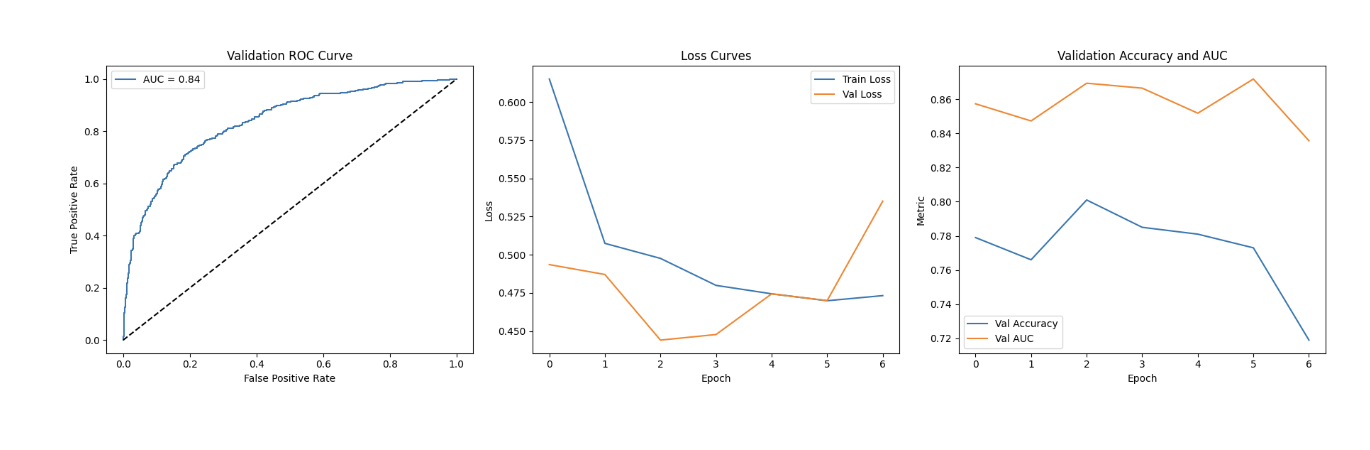


- Model 1 with sample: 5000, lr:0.0015, epochs: 8 and images NORMALIZED
    - CPU times: user 12.9 s, sys: 3.2 s, total: 16.1 s
    - Wall time: 1min 4s
    - Across 7 epochs, the model’s training loss consistently decreased, and validation accuracy and AUC generally improved, peaking at 80.7% accuracy and 0.8890 AUC in the final epoch. Although there was some fluctuation in validation loss and accuracy (notably a dip in epoch 6), the model finished strong, showing its best performance at the end of training.
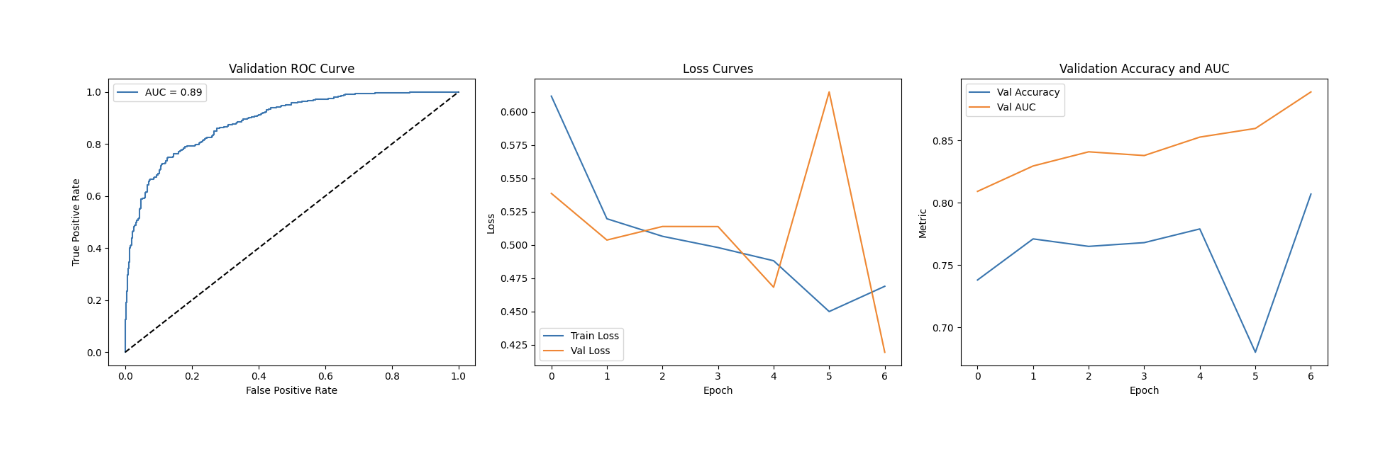

- Model 2 with sample: 5000, lr:0.0015, epochs: 8 and images
    - CPU times: user 25 s, sys: 3.13 s, total: 28.1 s
    - Wall time: 48.8 s
    - Over 7 epochs, the model’s training loss steadily decreased, and validation accuracy and AUC improved overall. After a modest start, the model achieved its best results in the final epoch, reaching 82.8% validation accuracy and a strong 0.9146 AUC. While there were some fluctuations in validation loss and metrics mid-training, the model demonstrated clear learning and finished with its highest performance.
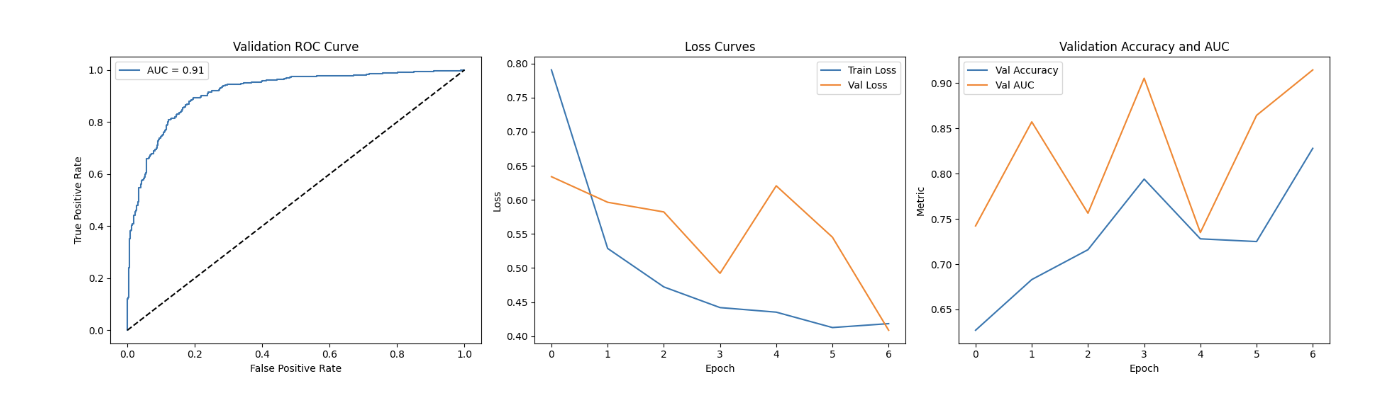

- Model 2 with sample: 5000, lr:0.0015, epochs: 8 and images NORMALIZED
    - CPU times: user 26 s, sys: 3.78 s, total: 29.8 s
    - Wall time: 53 s
    - Over 7 epochs, the model’s training and validation losses steadily decreased. Validation accuracy improved from 79.7% to 85.7%, and validation AUC increased from 0.88 to 0.93. The model showed strong and consistent performance, achieving its best results in the final epoch
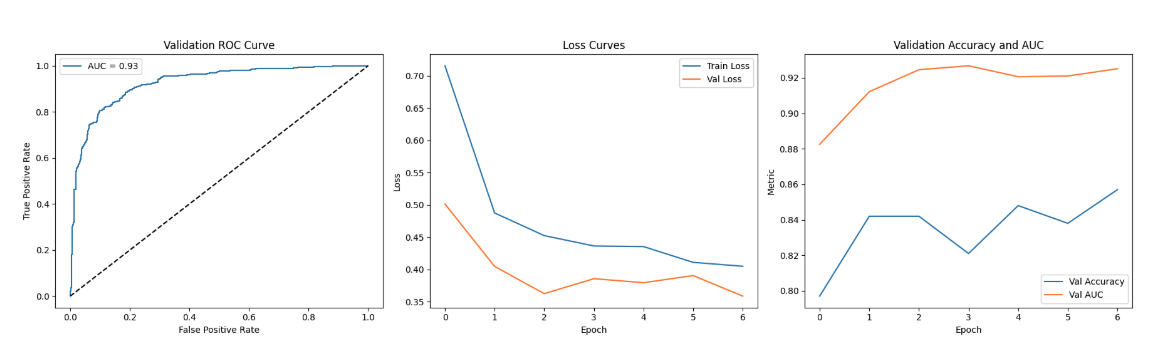


In [ ]:
#model1 = CancerDetector().to(device)
#model1_norm = CancerDetector().to(device)

#model2 = ComplexCancerDetector().to(device)
#model2_norm = ComplexCancerDetector().to(device)

In [ ]:
%%time
# model1
print(f'Runnig model 1 with sample: {SAMPLE_N}, lr:{LR}, epochs: {EPOCHS}')
train_losses, val_losses, val_accuracies, val_aucs, fpr, tpr,auc_score = test_model(model, train_loader, val_loader, device, lr=LR, num_epochs=EPOCHS)
print_metrics(train_losses, val_losses, val_accuracies, val_aucs, fpr, tpr,auc_score)

In [ ]:
##%%time
# model1 normalized
#print(f'Runnig model 1 with sample: {SAMPLE_N}, lr:{LR}, epochs: {EPOCHS} and normalized images')
#train_losses, val_losses, val_accuracies, val_aucs, fpr, tpr,auc_score = test_model(model1_norm, train_loader_norm, val_loader_norm, device, lr=LR, num_epochs=EPOCHS)
#print_metrics(train_losses, val_losses, val_accuracies, val_aucs, fpr, tpr,auc_score)

##%%time
#print(f'Runnig model 2 with sample: {SAMPLE_N}, lr:{LR}, epochs: {EPOCHS}')
#train_losses, val_losses, val_accuracies, val_aucs, fpr, tpr,auc_score = test_model(model2, train_loader, val_loader, device, lr=LR, num_epochs=EPOCHS)
#print_metrics(train_losses, val_losses, val_accuracies, val_aucs, fpr, tpr,auc_score)

##%%time
##print(f'Runnig model 1 with sample: {SAMPLE_N}, lr:{LR}, epochs: {EPOCHS}')
##train_losses, val_losses, val_accuracies, val_aucs, fpr, tpr,auc_score = test_model(model2_norm, train_loader_norm, val_loader_norm, device, lr=LR, num_epochs=EPOCHS)
##print_metrics(train_losses, val_losses, val_accuracies, val_aucs, fpr, tpr,auc_score)


## Perform predictions in test data and submit results

### Model selection

**Model 1 without normalization** because it offers a balance of strong performance, simplicity, and efficiency:

- Achieved a peak validation accuracy of 80.1% and a high AUC of 0.8718, demonstrating good discriminative ability and reliable learning progress across epochs.

- Trained quickly (59.4 seconds wall time), and both training and validation losses decreased as expected, indicating effective learning without major instability or divergence.

- Simplicity: By not including normalization, the model architecture and data pipeline remain simpler, which can reduce potential sources of error, lower computational overhead, and make deployment more straightforward.

- Normalization sometimes improved metrics slightly in other configurations, the gains were marginal for Model 1, and the unnormalized model still performed robustly, especially in terms of AUC, which is crucial for binary classification tasks like yours.

- The CPU and wall times are among the lowest across all tested models, making Model 1 without normalization a practical choice for faster experimentation and inference.

In [ ]:
# Create datasets
test_annotations_file = '/kaggle/input/histopathologic-cancer-detection/sample_submission.csv'
test_img_dir = "/kaggle/input/histopathologic-cancer-detection/test/"

test_df = pd.read_csv(test_annotations_file)

# Create datasets
test_dataset = HistoData(test_df, test_img_dir)#, transform=train_transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False,num_workers=4, pin_memory=True)

model.eval()
all_ids = []
all_preds = []

with torch.no_grad():
    for images, label, ids in test_loader:
        images = images.to(device)
        outputs = model(images).squeeze()
        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).int()  # Convert probabilities to 0 or 1
        all_preds.extend(preds.cpu().numpy())
        all_ids.extend(ids)  # Ensure your Dataset returns IDs


In [ ]:
submission = pd.DataFrame({'id': all_ids, 'label': all_preds})
submission.to_csv('/kaggle/working/submission.csv', index=False)